In [1]:
from mxnet import gluon, init, nd, autograd
from mxnet.contrib import text
from mxnet.gluon import data as gdata, loss as gloss, nn, utils as gutils
import collections
import pickle as pk
import numpy as np
import sys
import pandas as pd
sys.path.append('X:/Projects/MDW/temp/code')
from MWE import tokenizer
from post_pattern import patterns
import re
import random
import matplotlib.pyplot as plt

make sure you have d2l 0.8.7. Otherwise you may run into undefined functions.

In [2]:
import d2l
d2l.__version__

'0.8.7'

this is the training set Zhong provided.

In [3]:
raw_data = pd.read_csv(r'X:/Projects/MDW/Export/mdwchen5.csv') 

same as the other file. Feel free to make any changes. I feel that this is the lower hanging fruit.

In [4]:
def clean_text(text,rgx,sep=''):
    return re.sub(rgx, sep, text)

def rid_of_regex(x,regex):
        if re.search(regex,x):
            return x[re.search(regex,x).span()[1]:]
        else:
            return x
        
def apply_regex(f,regex,x):
    return list(map(lambda x:f(x,regex),x))

In [5]:
def cleanText(data):
    phone = re.compile(r'\b\d{3}.{0,1}\d{3}.{0,1}\d{4}(HOME|CELL|MOBILE|PER|OTHER)?\b') 
    date = re.compile(r'\d{1,2}/+\d{1,2}/+\d{2,4}')
    date1 = re.compile(r'\d{2}/{0,1}\d{2}/{0,1}\d{2,4}')
    state = re.compile(r'\b(AL|AK|AZ|AR|CA|CO|CT|DE|FL|GA|HI|ID|IL|IN|IA|KS|KY|LA|ME|MD|MA|MI|MN|MS|MO|MT|NE|NV|NH|NJ|NM|NY|NC|ND|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VT|VA|WA|WV|WI|WY)\d{5}\b')
    country = re.compile(r'(JAPAN|MEXICO|ISRAEL|CHINA|THAILAND|PANAMA|AUSTRALIA|CANADA|PHILIPPINES|HOLLAND|INDIA|COSTA RICA|UNITED KINDOM|UK|GERMANY|BRAZIL|DOMINICAN|TAIWAN|KOREA|RUSSIA|GUADERRAMA)')

    test = apply_regex(clean_text,phone,data.mtext.values)
    test = apply_regex(rid_of_regex,state,test)
    test = apply_regex(rid_of_regex,country,test)
    test = apply_regex(clean_text,date,test)
    test = apply_regex(clean_text,date1,test)
    test= list(map(lambda x : ' '.join(x),map(lambda x :[x[0]+x[1] for x in re.findall('([A-Z]+)|([0-9]+)',x)],test)))
    return test

In [6]:
raw_data['mtext']=cleanText(raw_data)

In [7]:
raw_data

,mwid,clssn,mtext,t1fst,t1sec,t1fstscr,t1secscr,fo
0,788535,1305290,Y 01 DEATH UPX 2560 HP PLEASE SEE W 1 RW 01 0 ...,C1,C9,3,1,PC1
1,759740,1461118,Y 01 SMI REFUND 2560 HP SEE REMARKS LZB 01 0 1...,C3,NaN,8,0,PC1
2,754013,3426250,A Y 01 SMI 2560 HSWI 01 0 1018 018 DATE CATEGO...,C3,NaN,7,0,PC1
3,772554,4482611,T Y 01 ESTIMATE 2560 2 IVY 01 0 1018 018 DATE ...,C21,NaN,4,0,PC1
4,845176,4488411,NH IS REQUESTING 1099 FOR PROOF OF WHAT WAS CR...,C27,C3,2,2,PC1
5,840718,4728777,PLEASE PROVIDE STATUS OF DEC EFFECT THANK YOU ...,C9,C25,3,2,PC7
6,851344,5489192,A Y 01 BENEFIT AMT 2560 ACT 01 0 1018 018 DATE...,C3,C4,3,1,PC1
7,787742,6849274,NEED TO CHANGE THE PAYMENT HISTORY TO SHOW CES...,C9,C19,12,5,PC7
8,873667,2381243,A Y 02 VOL PMT CYC AGREE VOL PMT CYC 2560 HP Y...,C2,NaN,1,0,PC1
9,876482,2522026,Y 01 BACKPAY 2560 HP YES WO S 3001 0 01 0 1018...,C18,C17,2,1,PC7


if we decide to use our pre-trained word embeddings, it is neccessary to use the following objects from the training too.

In [8]:
import pickle as pk
caches_url = 'X:/Projects/MDW/temp/code/cachesMay30.sav'
caches = pk.load(open(caches_url,'rb'))
idx_to_token = caches['idx_to_token']
token_to_idx = caches['token_to_idx']
vocab = caches['vocab']
input_dim = caches['input_dim']
#output_dim = caches['embed_size']
# this load pre-trained model from net.params file.
# notice that net has to be defined the same way the pre-trained model is
# otherwise you will get error.

#from mxnet.gluon import nn
#net = nn.Sequential()
#net.add(nn.Embedding(input_dim=input_dim, output_dim=output_dim),
#        nn.Embedding(input_dim=input_dim, output_dim=output_dim))
#net.load_parameters('X:/Projects/MDW/temp/code/netMay30.params')

def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data()
    x = W[token_to_idx[query_token.upper()]]
    # adding 1e-9 for stability
    cos = nd.dot(W, x) / (nd.sum(W * W, axis=1) * nd.sum(x * x) + 1e-9).sqrt()
    topk = nd.topk(cos, k=k+1, ret_typ='indices').asnumpy().astype('int32')
    for i in topk[1:]:  # delet the input
        print('cosine sim=%.3f: %s' % (cos[i].asscalar(), (idx_to_token[i])))

In [9]:
#textnet.embedding.weight.data()[token_to_idx['man'.upper()]]

In [10]:
#get_similar_tokens('STUDENT', 5, net[0])

encode the categories.

In [11]:
y_encoder = {tk: idx for idx, tk in enumerate(set(raw_data['t1fst'].values))}
y_shape = len(y_encoder) - 1

In [12]:
raw_data=raw_data.replace({"t1fst":y_encoder,"t1sec":y_encoder})

In [13]:
raw_data[raw_data.clssn==4327432]

,mwid,clssn,mtext,t1fst,t1sec,t1fstscr,t1secscr,fo
89,792325,4327432,ANH DEC D IS NOT DUE THE CHECK PAYEE REPORTS N...,25,0,1,0,PC1


In [14]:
raw_data['t1fst']=raw_data['t1fst']-1

now t1fst == -1 is the unlabeled data

In [15]:
raw_data[raw_data.t1fst==-1]

,mwid,clssn,mtext,t1fst,t1sec,t1fstscr,t1secscr,fo
13,730058,4568000,Y 01 561 2560 HP YES MYN 01 0 1018 9 HA IS REQ...,-1,0,0,0,PC1
21,775038,2347998,A Y 01 RECALCULATE 2560 DM 01 0 1018 018 DATE ...,-1,0,0,0,PC1
26,856703,7287952,2560 H 9 DONE 2560 PD WIDOW U P WCUE 1001 0 01...,-1,0,0,0,PC1
35,754466,3502985,A Y 02 BACKPAY 2560 OWN RP 2560 HP SEE RMKS AB...,-1,0,0,0,PC7
42,753720,12487051,A Y 02 EARNINGS 2560 EARNINGS 2560 POS 2018 AR...,-1,0,0,0,PC1
46,747350,2127318,Y 02 UNDERPAYMEN 2560 HP Y RE U P W 12 T 01 0 ...,-1,0,0,0,PC1
49,856484,4245021,BIC D IS CHECKING STATUS OF LSDP DUE PLEASE IS...,-1,0,0,0,PC1
57,746438,2443612,PLEASE RELEASE U P OF 2 384 00 TO C 1 JULIE HI...,-1,0,0,0,PC1
82,732526,16567929,A Y 01 BACK PAY 2560 SEE REMARKS T E 01 0 1018...,-1,0,0,0,PC7
88,731217,3703815,ANH IS INQUIRING ABOUT THE STATUS OF HIS FRENC...,-1,0,0,0,PC8


a sample of pre-processed mdw:

In [16]:
raw_data['mtext'][1]

'Y 01 SMI REFUND 2560 HP SEE REMARKS LZB 01 0 1018 9 CLAIMANT CAME INTO FO 012 REGARDING HER SMI PREMIUMS THAT WERE DEDUCTED FROM HER FIRST SSA CHECK DATED APPEARS SSA IS DEDUCTING PREMIUMS FROM APRIL THROUGH JULY FROM THIS PAYMENT HOWEVER CLAIMANT SENT IN A CHECK TO MEDICARE IN THE AMOUNT OF 271 TO COVER APRIL AND MAY KNOWING HER CHECK WOULD BEGIN IN JUNE AND THAT WE WOULD DEDUCT THAT PREMIUM PLEASE REFUND NH THREE MONTHS OF PREMIUMS SINCE SHE PAID THROUGH JULY WE SHOULD REFUND HER THE 271 FOR APRIL AND MAY THE CHECK SHE SENT AND JULY THAT WE DEDUCTED FROM HER JUNE CHECK EARLY THE TOTAL REFUND SHOULD BE 406 50 THANK YOU TRX 012'

picking cases we are relatively confident as training data(labeled_data). for those that we are not sure, it is no_label_data, which is not used in training or testing, but we tried to predict these after training.

In [17]:
no_label_data = raw_data[raw_data.t1fst==-1][["mtext","t1fst"]]
labeled_data = raw_data[raw_data.t1fstscr/raw_data.t1secscr>1.25][["mtext","t1fst"]]

last look of the processed mdw, labeled or unlabeled.

In [18]:
labeled_data.head()

,mtext,t1fst
0,Y 01 DEATH UPX 2560 HP PLEASE SEE W 1 RW 01 0 ...,27
1,Y 01 SMI REFUND 2560 HP SEE REMARKS LZB 01 0 1...,25
2,A Y 01 SMI 2560 HSWI 01 0 1018 018 DATE CATEGO...,25
3,T Y 01 ESTIMATE 2560 2 IVY 01 0 1018 018 DATE ...,16
5,PLEASE PROVIDE STATUS OF DEC EFFECT THANK YOU ...,7


In [19]:
no_label_data.head()

,mtext,t1fst
13,Y 01 561 2560 HP YES MYN 01 0 1018 9 HA IS REQ...,-1
21,A Y 01 RECALCULATE 2560 DM 01 0 1018 018 DATE ...,-1
26,2560 H 9 DONE 2560 PD WIDOW U P WCUE 1001 0 01...,-1
35,A Y 02 BACKPAY 2560 OWN RP 2560 HP SEE RMKS AB...,-1
42,A Y 02 EARNINGS 2560 EARNINGS 2560 POS 2018 AR...,-1


In [20]:
labeled_data.shape

(118276, 2)

divide training and test set. the code is not very straightforward. anyhow...

In [21]:
from random import sample 
labeled_data = labeled_data.drop_duplicates(keep=False)
test_data = labeled_data.sample(n=len(labeled_data)//5, replace=False).drop_duplicates(keep=False)
train_data = pd.concat([labeled_data, test_data, test_data]).drop_duplicates(keep=False)

#train_data = labeled_data.loc[:len(labeled_data)*4//5,]
#test_data = labeled_data.loc[len(labeled_data)*4//5+1:,]

In [22]:
test_data.shape,train_data.shape

((23546, 2), (94184, 2))

how you do conv:

In [23]:
def corr1d(X, K):
    w = K.shape[0]
    Y = nd.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [24]:
def corr1d_multi_in(X, K):
    return nd.add_n(*[corr1d(x, k) for x, k in zip(X, K)])

In [25]:
def get_tokenized_mdw(data):
    """Get the tokenized mdw data set for classification."""
    def tokenizer(text):
        return [tok.upper() for tok in text.split(' ')]
    return [tokenizer(text) for text, _ in data]

In [26]:
#def get_vocab_mdw(data):
#    """Get the vocab for the mdw data set for classification."""
#    tokenized_data = get_tokenized_mdw(data)
#    counter = collections.Counter([tk for st in tokenized_data for tk in st])
#    return text.vocab.Vocabulary(counter, min_freq=5)

before training, we need to preprocess the mdws. padding and truncation are done here. then words are replaced by indices.

In [27]:
def preprocess_mdw(data, vocab):
    """Preprocess the mdw data set for classification."""
    max_l = 200

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))

    tokenized_data = get_tokenized_mdw(data)
    features = nd.array([pad(vocab.to_indices(x)) for x in tokenized_data])
    labels = nd.array([score for _, score in data])
    return features, labels

In [28]:
train_data=[[x['mtext'],x['t1fst']] for _,x in train_data.iterrows()] 

test_data=[[x['mtext'],x['t1fst']] for _,x in test_data.iterrows()] 

In [29]:
nolabel_data=[[x['mtext'],x['t1fst']] for _,x in no_label_data.iterrows()] 
nolabel_iter = gdata.DataLoader(gdata.ArrayDataset(
    *preprocess_mdw(nolabel_data, vocab)), 32)

define batch size and data iterators. 

In [30]:
batch_size = 32
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    *preprocess_mdw(train_data, vocab)), batch_size, shuffle=True)
test_iter = gdata.DataLoader(gdata.ArrayDataset(
    *preprocess_mdw(test_data, vocab)), batch_size)

mapping Zhong's code to the actual categories.

In [31]:
C_C={
    "C1":"Death Underpayment",
"C10":"Workers Compensation",
"C11":"Garnishment",
"C12":"Tax Levy",
"C13":"Attorney",
"C14":"Windfall Elimination Provision",
"C15":"Government Pension Offset",
"C16":"Change of Address",
"C17":"Direct Deposit ",
"C18":"Reinstatement",
"C19":"Benefit Explanation",
"C2":"SSI Offset",
"C20":"Voluntary Tax Withholding",
"C21":"Benefit Estimate",
"C22":"Benefit Adjustment",
"C23":"Limited Payability",
"C24":"Returned Check",
"C25":"DIBCESS",
"C26":"Anomalous Claim",
"C27":"1099 Benefit Statement",
"C28":"Work and Earnings",
"C29":"Steigerwald",
"C3":"Medicare",
"C30":"Recon",
"C4":"Claim",
"C5":"Conserved Funds",
"C6":"Recomp",
"C7":"Student Benefits",
"C8":"Non-receipt ",
"C9":"Overpayment"}


import pickle as pk
caches_url = 'X:/Projects/MDW/temp/code/cachesMay30.sav'
caches = {'idx_to_token': idx_to_token, 'token_to_idx': token_to_idx,'vocab':vocab,'input_dim':len(idx_to_token),
         'y_shape':y_shape,'y_encoder':y_encoder,'C_C':C_C,'test_data':test_data}
pk.dump(caches,open(caches_url,'wb'))

In [32]:
class TextCNN(nn.Block):
    def __init__(self, vocab, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # two embeddings here. constant_embedding is pre-trained, does not enter training
        # embedding enters training.
        self.constant_embedding = nn.Embedding(len(vocab), embed_size)
        #dropout layer prevents overfitting
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Dense(y_shape)
        self.pool = nn.GlobalMaxPool1D()
        self.convs = nn.Sequential()  # 
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.add(nn.Conv1D(c, k, activation='relu'))

    def forward(self, inputs):
        # concat two embeddings together
        embeddings = nd.concat(
            self.embedding(inputs), self.constant_embedding(inputs), dim=2)
        # this is the conv part.
        embeddings = embeddings.transpose((0, 2, 1))
        encoding = nd.concat(*[nd.flatten(
            self.pool(conv(embeddings))) for conv in self.convs], dim=1)
        # drop out and then a dense layer. 
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [33]:
def to_vec(query_token, embed):
    W = embed.weight.data()
    return W[token_to_idx[query_token]]

here we have 400 unigram filters, 100 bigram, 100 trigram and 50 quagram. is it how you spell it? textCNN initialized here.

In [34]:
embed_size, kernel_sizes, nums_channels = 50, [1, 2, 3, 4], [400, 100,100,50]
ctx = d2l.try_all_gpus()[0]
textnet = TextCNN(vocab, embed_size, kernel_sizes, nums_channels)
textnet.initialize(init.Xavier(), ctx=ctx)

load the previous trained embedding.

In [35]:
mdw_embedding=text.embedding.CustomEmbedding( r'\\nsc-isln-01-smb.nas.ssa.gov\ace/Projects/MDW/temp/code/mdw_dic_50_normalized.txt', vocabulary=vocab)

this is how we tell mxnet not to update constant_embedding during training.

In [36]:
textnet.embedding.weight.set_data(mdw_embedding.idx_to_vec)
textnet.constant_embedding.weight.set_data(mdw_embedding.idx_to_vec)
textnet.constant_embedding.collect_params().setattr('grad_req', 'null')

In [37]:
textnet 

TextCNN(
  (embedding): Embedding(49628 -> 50, float32)
  (constant_embedding): Embedding(49628 -> 50, float32)
  (dropout): Dropout(p = 0.5, axes=())
  (decoder): Dense(None -> 30, linear)
  (pool): GlobalMaxPool1D(size=(1,), stride=(1,), padding=(0,), ceil_mode=True)
  (convs): Sequential(
    (0): Conv1D(None -> 400, kernel_size=(1,), stride=(1,))
    (1): Conv1D(None -> 100, kernel_size=(2,), stride=(1,))
    (2): Conv1D(None -> 100, kernel_size=(3,), stride=(1,))
    (3): Conv1D(None -> 50, kernel_size=(4,), stride=(1,))
  )
)

In [38]:
lr, num_epochs = 0.001, 4
trainer = gluon.Trainer(textnet.collect_params(), 'adam', {'learning_rate': lr})
loss = gloss.SoftmaxCrossEntropyLoss()
d2l.train(train_iter, test_iter, textnet, loss, trainer, ctx, num_epochs)

training on cpu(0)
epoch 1, loss 0.4303, train acc 0.881, test acc 0.950, time 1309.3 sec
epoch 2, loss 0.1907, train acc 0.942, test acc 0.956, time 1325.5 sec
epoch 3, loss 0.1562, train acc 0.953, test acc 0.959, time 1331.4 sec
epoch 4, loss 0.1326, train acc 0.961, test acc 0.957, time 1324.4 sec


In [37]:
def softmax(X):
    X_exp =X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition  

def mdw_predict(x,textnet,output=True):
    '''x is in ['test',label] format'''
    if len(x)==1:
        x = x[0]
    if output == True:
        print(x[0])
    if x[1] != -1 and output == True:
        print('True label is: %s'%C_C[inv_map[x[1]]])
    y = textnet(preprocess_mdw([x], vocab)[0].as_in_context(mx.gpu()))
    if output == True:
        print("Predicted label is: %s"%C_C[inv_map[y.argmax(axis=1).asscalar()]])
        m=softmax(y).asnumpy()
        plt.hist(m)
        plt.show()
        plt.close()
    return C_C[inv_map[y.argmax(axis=1).asscalar()]],softmax(y).max().asscalar()

In [38]:
inv_map = {v-1: k for k, v in y_encoder.items()}

In [49]:
#temp = []
#for x, y in nolabel_data:
#    y = textnet(preprocess_mdw([[x,y]], vocab)[0].as_in_context(mx.gpu()))
#    if y.max(axis=1)<0.5:
#        temp.append(x)

In [39]:
import mxnet as mx

In [40]:
random.sample(test_data,1)

[['C 2 Y 02 SURVIVOR ADM T 2 OP 2560 IIAA 01 0 2036 036 DATE CATEGORY ADM CONTACT PERSON IS THE CLAIMANT MOTHER DEBRA WALLS CALLED BECAUSE C 2 WAS RECEIVING BENEFITS ON HER SSN 137 70 4109 C 1 BUT THEY STOPPED DUE TO HER DIBCESS THEY ALSO STOPPED ON FATHER S RECORD 152 74 1460 C 2 BUT C 2 WAS STILL DISABLED GETTING SSI DIB BENEFITS WOULDN T HE BE ENTITLED TO A SURVIVOR S BENEFIT AS A CDB ON FATHER S RECORD PLEASE REVIEW THANKS CODE PC 5 UNIT MOD 3 JOB TITLE TST EE MARY SOSNOWSKI DATE CATEGORY 2560 PAYEE NAME DEBRA WALLS FOR JAMES A WILLIAMS CONTACT ADDRESS PO BOX 118 CLEMENTON NJ 08021 0215 CONTACT PHONE PHONE LOCATION HOME PAYEE QUESTIONING OVERPAYMENT C 2 IS LAF T 6 DICESS WAS NOT ENTITLED NOR RECEIVEDANY MONTHLY BENEFITS FROM NH WAS ENTITLED TO BENEFITS ON CLAIM NBR 137 70 4109 C 1 PAYMENTS WERE NULL AS OF PLS REV RECORDS TO DETERMINE REASON FOR OVERPAYMENT TSCJ 06 4421 INIETO',
  14]]

A Y 01 T 2 OP 2560 Y 7 ZJR 01 0 1018 018 DATE CATEGORY 2560 CONTACT PERSON IS THE CLAIMANT D NH REQUESTED A DETAILED EXPLANATION ON O P E 01 EBAL 10919 34 ALSO FOR C 1 AND C 2 PROTEST STOP RECOVERY WAS INPUT CODE D 72 UNIT 50048 JOB TITLE TSR EE JOEL R SANCHEZ
True label is: Overpayment
Predicted label is: Overpayment


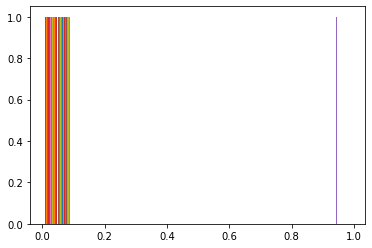

('Overpayment', 0.9957853)

In [44]:
mdw_predict(random.sample(test_data,1),textnet,output=True)

In [ ]:
stop here. following are just random tests.

In [128]:
def cleanText(text):
    phone = re.compile(r'\b\d{3}.{0,1}\d{3}.{0,1}\d{4}(HOME|CELL|MOBILE|PER|OTHER)?\b') 
    date = re.compile(r'\d{1,2}/+\d{1,2}/+\d{2,4}')
    date1 = re.compile(r'\d{2}/{0,1}\d{2}/{0,1}\d{2,4}')
    state = re.compile(r'\b(AL|AK|AZ|AR|CA|CO|CT|DE|FL|GA|HI|ID|IL|IN|IA|KS|KY|LA|ME|MD|MA|MI|MN|MS|MO|MT|NE|NV|NH|NJ|NM|NY|NC|ND|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VT|VA|WA|WV|WI|WY)\d{5}\b')
    country = re.compile(r'(JAPAN|MEXICO|ISRAEL|CHINA|THAILAND|PANAMA|AUSTRALIA|CANADA|PHILIPPINES|HOLLAND|INDIA|COSTA RICA|UNITED KINDOM|UK|GERMANY|BRAZIL|DOMINICAN|TAIWAN|KOREA|RUSSIA|GUADERRAMA)')

    test = apply_regex(clean_text,phone,text)
    test = apply_regex(rid_of_regex,state,test)
    test = apply_regex(rid_of_regex,country,test)
    test = apply_regex(clean_text,date,test)
    test = apply_regex(clean_text,date1,test)
    test= list(map(lambda x : ' '.join(x),map(lambda x :[x[0]+x[1] for x in re.findall('([A-Z]+)|([0-9]+)',x)],test)))
    return test

In [287]:
import nltk
w1 = set('b')
w2 = set('attorney')
 
nltk.jaccard_distance(w1, w2)



1.0

In [403]:
import time
start = time.time()
for t in test_data:
    mdw_predict(t,textnet)
print(time.time()-start)

223.7227144241333


In [402]:
print(len(test_data))

109822


In [132]:
random.sample(list(no_label_data.mtext.values),1)[0]

'A Y 01 S 6 ISSUE 2560 Q 1 01 0 1018 018 DATE CATEGORY 2560 CONTACT PERSON IS THE CLAIMANT NH CALLING BECAUSE OF NOTICE REC D INFORMING HIM OF SUSPENDED STATUS NH SUSPENDED DUE TO ADDRESS ADDRESS IS VALID HE REC D THE NOTICE SO ADDRESS IS GOOD IF THERE IS A OTHER REASON FOR SUSPENSE PLEASE CONTACT NH DIRECTLY LETTER ISSUED WAS NOT SPECIFIC NH CLAIMS CDRFORMS WERE RETURNED PLEASE DEVLEOP THANK YOU CODE G 20 UNIT 95 CMS JOB TITLE TSR EE CHRISTINA M STOSHICK'

NH IS REQUESTING AN UPDATE OF THE BACK PAY SHE WANTS TO KNOW A TIME FRAME FOR THE BACK PAY TO BE PROCESSED MP 0 01 BACKPAY 2560 HP PLZ HELP KX 3 K 1001 0 01 0 1000 000
Predicted label is: Reinstatement


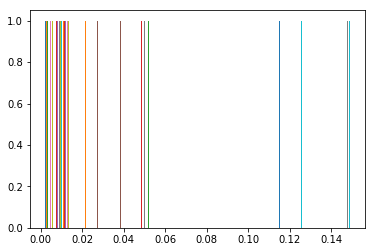

('Reinstatement', 0.15035322)

In [168]:
t=random.sample(list(no_label_data.mtext.values),1)[0]
t=cleanText([t])
t.append(-1)
mdw_predict(t,textnet)

In [339]:
get_similar_tokens('irmma', 10,net[0])

cosine sim=0.974: IRMAA
cosine sim=0.904: IRRMA
cosine sim=0.832: IRMA
cosine sim=0.785: PREMIUM
cosine sim=0.764: EXTRA
cosine sim=0.761: SURCHARGE
cosine sim=0.748: LCE
cosine sim=0.747: COLA
cosine sim=0.741: PENALTY
cosine sim=0.737: MEDICARE


In [290]:
def to_vec(query_token, embed):
    W = embed.weight.data()
    return W[token_to_idx[query_token]]

In [303]:
nd.norm(to_vec('IRMAA',textnet.embedding)-to_vec('IRMMA',textnet.embedding))


[1.086584]
<NDArray 1 @gpu(0)>

In [293]:
to_vec('IRMAA',textnet.embedding)


[ 0.00561888 -0.09356435 -0.1808306   0.12999058 -0.26821637  0.23409535
 -0.42693195 -0.24741603 -0.24211018  0.02739589  0.08314547  0.12060302
 -0.4014776   0.24852435  0.01956573 -0.53753364 -0.29112694 -0.30662483
  0.1888835   0.37300947  0.24305102 -0.36055386 -0.48061314  0.4845088
 -0.02123025 -0.238081    0.34899026  0.49492994  0.27182004  0.2455002
  0.18864883  0.18048002 -0.4002455   0.3039294  -0.07281417 -0.27333775
 -0.16473398 -0.432996   -0.3910344   0.2813746  -0.22064604  0.07746987
  0.23763154  0.11332429 -0.1294922  -0.18185821 -0.1519389  -0.0270189
 -0.23399298 -0.11180773]
<NDArray 50 @gpu(0)>

In [117]:
textnet.save_parameters('X:/Projects/MDW/temp/code/textnet2019.params')

# End here

In [518]:
import pandas as pd
forlabelMDW = pd.read_excel(r'X:\Projects\MDW\temp\Copy of ForLabelingMDW(3-25to3-29).xlsx')

In [505]:
forlabelMDW.loc[20,'Prediction']

'Benefit Explanation'

In [519]:
for i in forlabelMDW.index:
    t=cleanText([forlabelMDW.Mtext.values[i]])
    t.append(-1)
    s = mdw_predict(t,textnet,output=False)
    if s[1] > 0.5:    
        forlabelMDW.loc[i,'Prediction']=s[0]
        forlabelMDW.loc[i,'Confidence']=s[1]

In [520]:
forlabelMDW.to_excel(r'X:\Projects\MDW\temp\ForLabelingMDW(3-25to3-29)w_predictions.xlsx')

In [455]:
textnet.constant_embedding.weight.data()[808]


[ 0.41928962 -0.05232305  0.06732052  0.04166986 -0.00049291  0.2054341
  0.05663381  0.04308201  0.03609613 -0.04456946  0.087288    0.02740583
 -0.17397396 -0.12928203 -0.18081066 -0.25023207 -0.07720701 -0.04341961
  0.19286515  0.07844424  0.17464098 -0.06129236 -0.21701384  0.19253273
  0.00569795 -0.03014432 -0.206507    0.01358892  0.06068921  0.270307
  0.03530313 -0.15027536  0.08013483  0.17520432  0.12777956 -0.20505908
  0.00137738 -0.13433182  0.02645227  0.11845467 -0.01744765  0.10970467
  0.11093113 -0.13894762  0.12395454 -0.30787936 -0.01800296  0.07222912
 -0.02455311 -0.10716875]
<NDArray 50 @gpu(0)>

In [77]:
textnet1

TextCNN(
  (embedding): Embedding(49628 -> 50, float32)
  (constant_embedding): Embedding(49628 -> 50, float32)
  (dropout): Dropout(p = 0.5, axes=())
  (decoder): Dense(None -> 25, linear)
  (pool): GlobalMaxPool1D(size=(1,), stride=(1,), padding=(0,), ceil_mode=True)
  (convs): Sequential(
    (0): Conv1D(None -> 400, kernel_size=(1,), stride=(1,))
    (1): Conv1D(None -> 100, kernel_size=(2,), stride=(1,))
    (2): Conv1D(None -> 100, kernel_size=(3,), stride=(1,))
    (3): Conv1D(None -> 50, kernel_size=(4,), stride=(1,))
  )
)

In [78]:
textnet1.load_parameters('X:/Projects/MDW/temp/code/textnetMar19_50.params')

In [43]:
x=preprocess_mdw(random.sample(test_data,1), vocab)[0].as_in_context(mx.gpu())

In [44]:
import mxnet as mx
textnet.embedding(x)


[[[ 0.0889896  -0.07846874  0.2587647  ...  0.33132428 -0.06544449
   -0.03903337]
  [ 0.07750888 -0.17100939  0.09104776 ...  0.11553249 -0.09299058
   -0.0223031 ]
  [ 0.00849385 -0.11474949  0.01498142 ... -0.0034818   0.04108622
    0.10198218]
  ...
  [-0.01539255  0.14308195  0.09002183 ...  0.13329844 -0.18069859
    0.00943536]
  [-0.01539255  0.14308195  0.09002183 ...  0.13329844 -0.18069859
    0.00943536]
  [-0.01539255  0.14308195  0.09002183 ...  0.13329844 -0.18069859
    0.00943536]]]
<NDArray 1x10000x50 @gpu(0)>

In [446]:
for i in [0,1,2,3]:
    for j in range(textnet.convs[i].weight.data().shape[0]):
        x=pd.DataFrame(textnet.convs[i].weight.data()[j].asnumpy())
        x.to_excel(r'X:\Projects\MDW\Export\model params\conv_%d_%d_%s.xlsx'%(i,j,'weight'))

In [444]:
range(textnet.convs[2].weight.data().shape[0])


SyntaxError: invalid syntax (<ipython-input-444-35a00d2321bc>, line 1)

In [108]:
bias=textnet.convs[0].bias.data().as_in_context(mx.gpu())
weight=textnet.convs[0].weight.data().as_in_context(mx.gpu())
nd.dot(weight,nd.concat(textnet.embedding(x), textnet.constant_embedding(x), dim=2).transpose((0, 2, 1)))

NameError: name 'x' is not defined

In [4]:
Nominatim

geopy.geocoders.osm.Nominatim

In [5]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)

print((location.latitude, location.longitude))
print(location.raw)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


Backwerk, Potsdamer Platz, Tiergarten, Mitte, Berlin, 10785, Deutschland
(52.50958575, 13.3762845319028)
{'place_id': 176241040, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 464904422, 'lat': '52.50958575', 'lon': '13.3762845319028', 'display_name': 'Backwerk, Potsdamer Platz, Tiergarten, Mitte, Berlin, 10785, Deutschland', 'address': {'bakery': 'Backwerk', 'footway': 'Potsdamer Platz', 'suburb': 'Tiergarten', 'city_district': 'Mitte', 'state': 'Berlin', 'postcode': '10785', 'country': 'Deutschland', 'country_code': 'de'}, 'boundingbox': ['52.5095298', '52.5096533', '13.3762456', '13.3763382']}


In [6]:
a = ['pc1', 'pc3', 'pc2']

In [10]:
", ".join(a) + ' wirte'

'pc1, pc3, pc2 wirte'

In [12]:
d= {'a' : 12, 'b' : 44, 'ab' : 23}

In [13]:
d

{'a': 12, 'b': 44, 'ab': 23}

In [16]:
", ".join(d.keys())

'a, b, ab'

In [17]:
gdd = {}

In [47]:
exp = Exception("BAZINGA")

In [48]:


from email.mime.text import MIMEText
import smtplib

from_email = 'daniel.xia@ssa.gov'
to_email = 'daniel.xia@ssa.gov'

msg = MIMEText(exp)
msg['Subject'] = 'MDW Write CSV Failure'
msg['From'] = from_email
msg['To'] = to_email

s = smtplib.SMTP('mailrelay.ssa.gov')   
s.sendmail(from_email, to_email, msg.as_string())
s.quit()


AttributeError: 'Exception' object has no attribute 'encode'

In [32]:
raw_data.shape

(153689, 8)

In [52]:
str(exp)

'BAZINGA'

In [41]:
!dir

 Volume in drive X is ace
 Volume Serial Number is 009A-9A03

 Directory of X:\Projects\MDW\temp\code

11/05/2019  10:14 AM    <DIR>          .
11/05/2019  05:45 AM    <DIR>          ..
03/08/2019  05:36 PM        79,404,944 netMar8.params
04/01/2019  11:46 AM        60,082,745 cachesApril1.sav
10/29/2019  01:46 PM                 0 untitled.txt
03/07/2019  12:59 PM        83,669,793 textnetMar5.params
04/01/2019  11:58 AM        20,359,671 textnetApril1_50.params
10/31/2019  01:59 PM    <DIR>          .ipynb_checkpoints
03/22/2019  07:12 AM            16,922 text8.txt
03/05/2019  10:19 AM       105,188,547 textnet.sav
03/20/2019  08:23 AM        19,851,344 netMar19.params
11/30/2018  08:02 AM         5,957,139 tt.xlsx
10/30/2019  12:24 PM            84,731 train_MDW - Dan.ipynb
03/15/2019  01:06 PM        81,233,271 textnetMar13_200.params
10/31/2019  12:31 PM             9,252 Untitled4.ipynb
11/29/2018  02:52 PM             1,768 post_pattern.py
03/08/2019  02:53 PM             8,86

In [45]:
import os
os.rename(r"X:\Projects\MDW\temp\code\untitled.txt", r"X:\Projects\MDW\temp\untitled1.txt")

In [53]:
from_email = 'daniel.xia@ssa.gov'
to_email = 'daniel.xia@ssa.gov'

msg = MIMEText(str(exp))
msg['Subject'] = 'MDW Write CSV Failure'
msg['From'] = from_email
msg['To'] = to_email
msg['cc'] = ";".join[to_email, to_email]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [54]:
";".join[to_email, to_email]

TypeError: 'builtin_function_or_method' object is not subscriptable